In [2]:
import matplotlib.pyplot as plt
#set font to liberation sans
plt.rcParams['font.family'] = 'Liberation Serif'
import numpy as np
from core import Config
from data_train import set_config_params
import os

/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
CUDA_VISIBLE_DEVICES: None


In [4]:
model_name = "ortho_haar_medium_single_gpu"

config = Config()
output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)



ORTHO HAAR MEDIUM MODEL 1 GPU




/tmp/ipykernel_2811121/3014848319.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(9, 4))


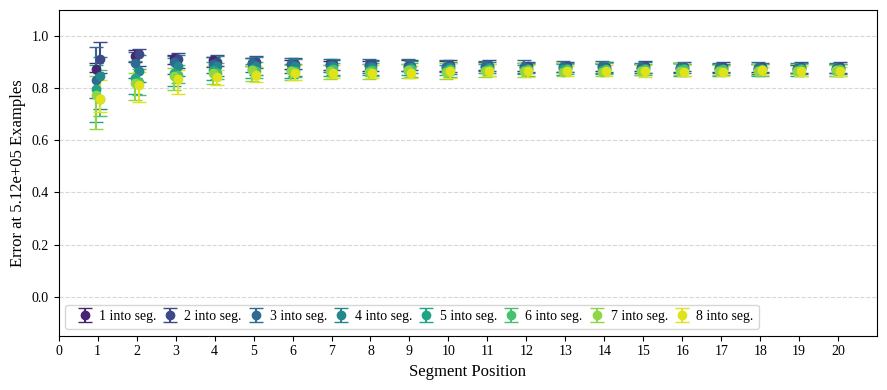

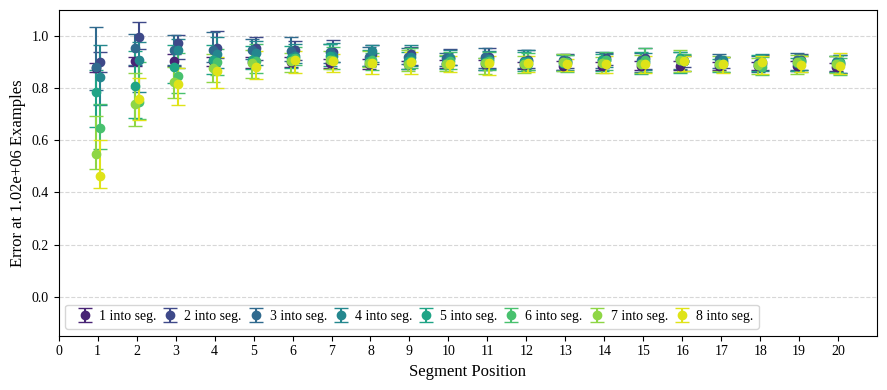

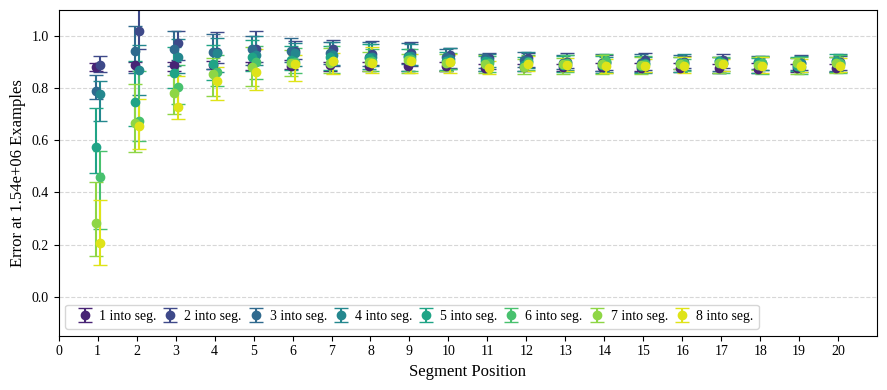

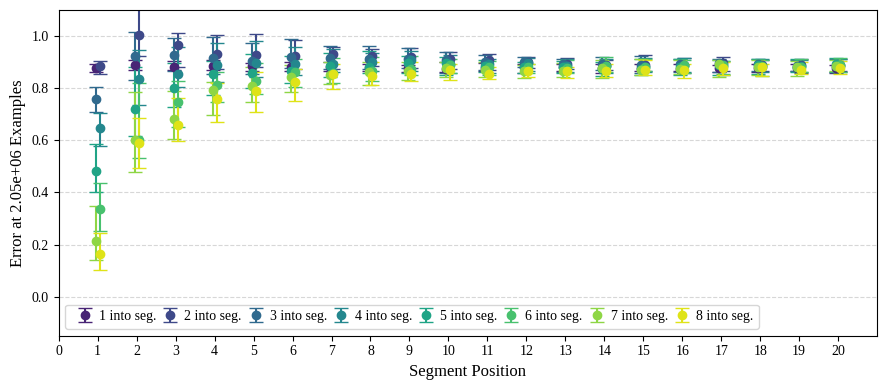

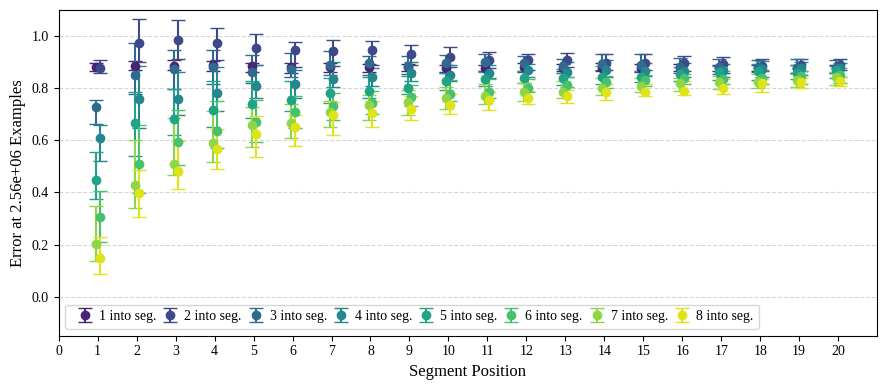

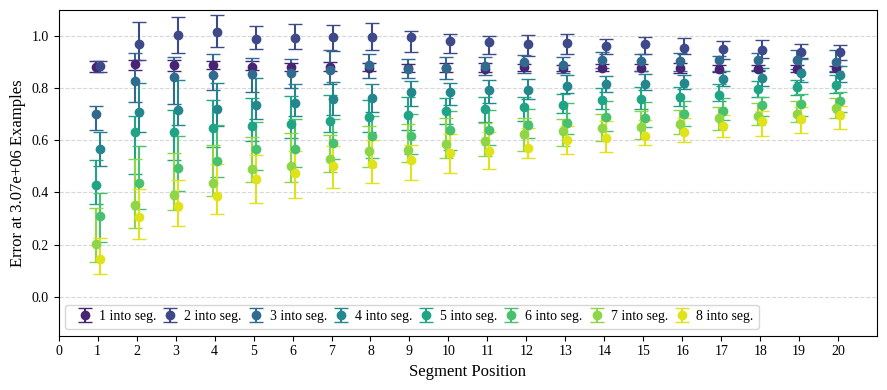

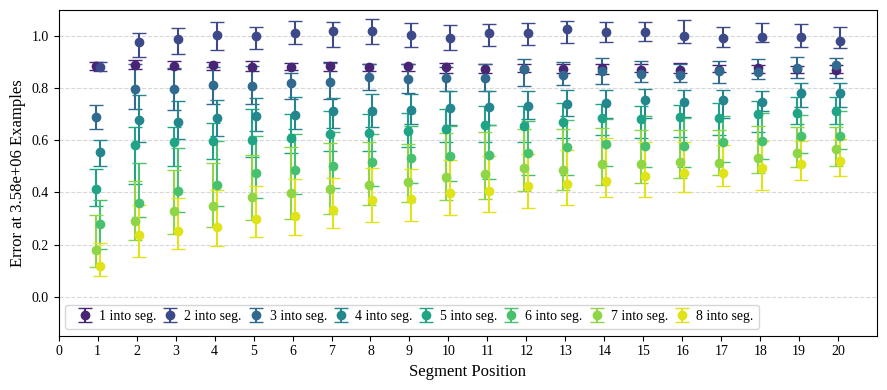

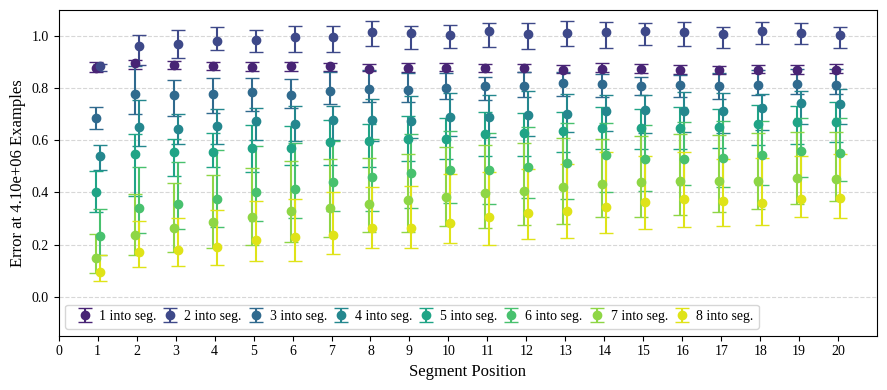

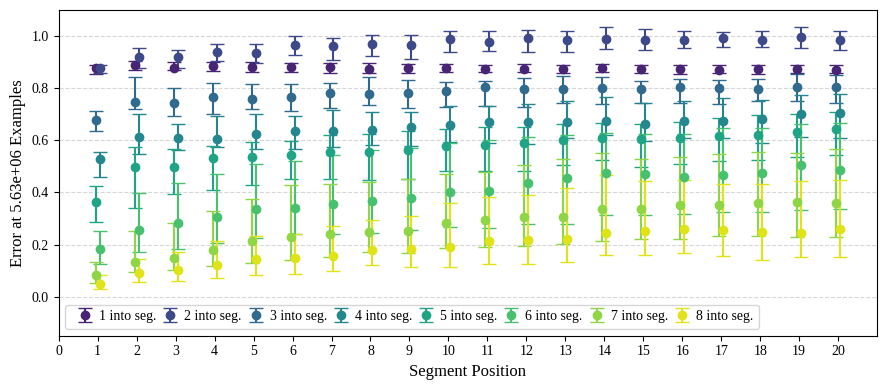

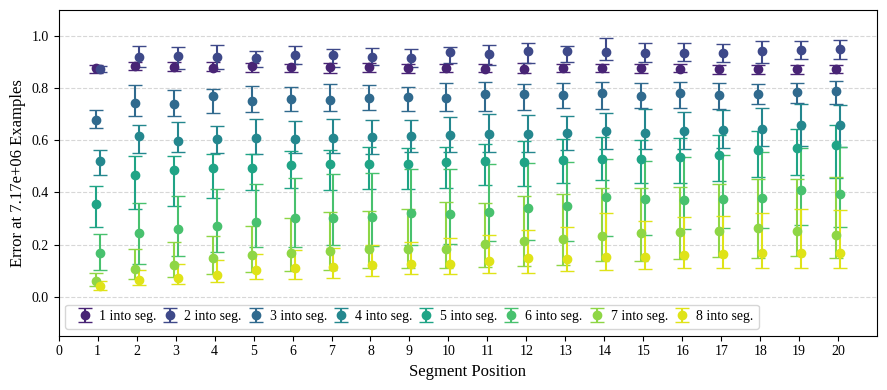

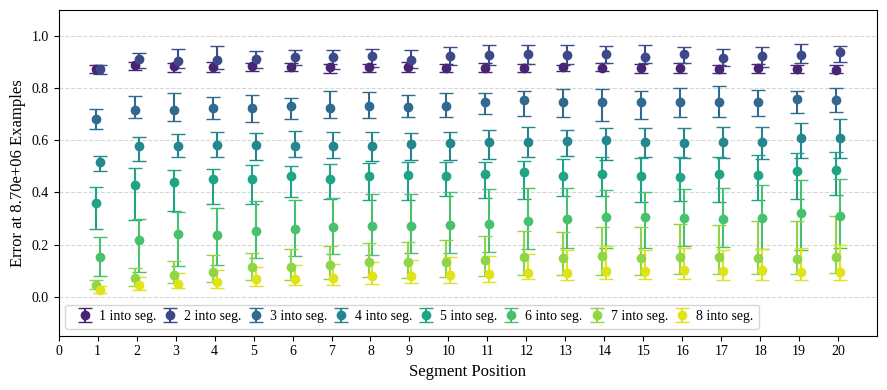

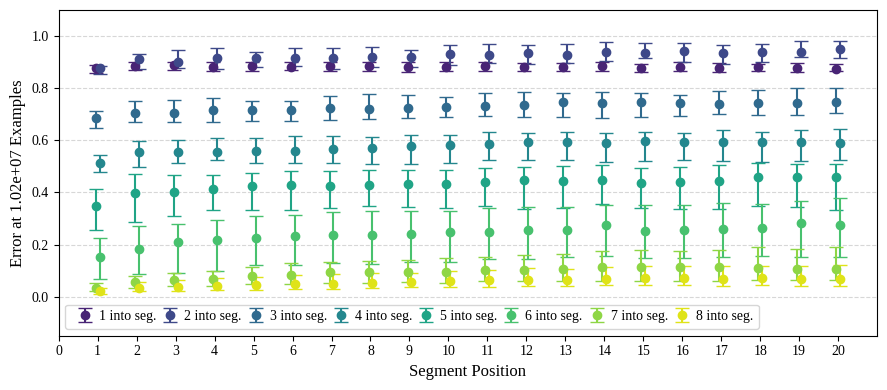

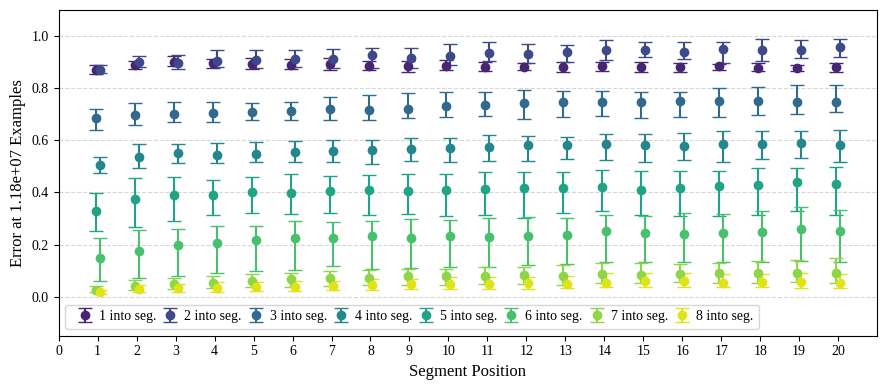

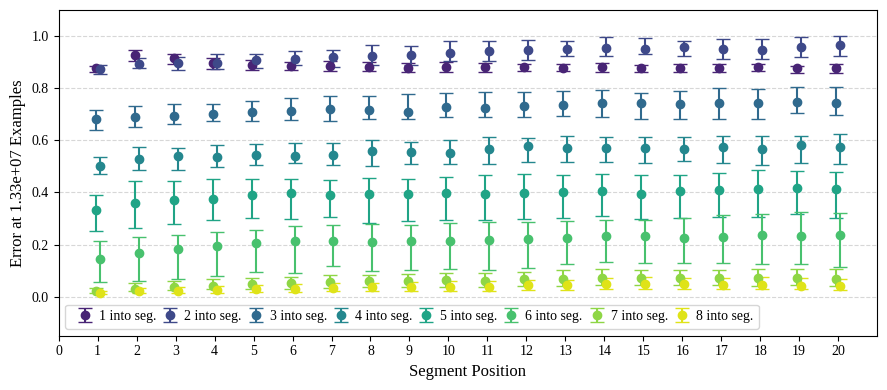

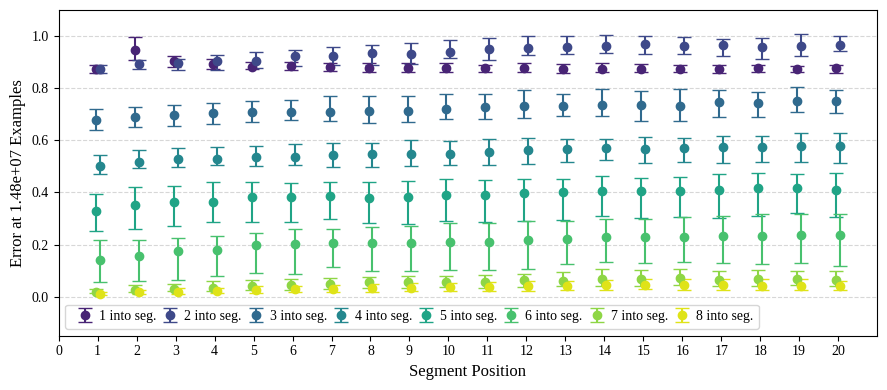

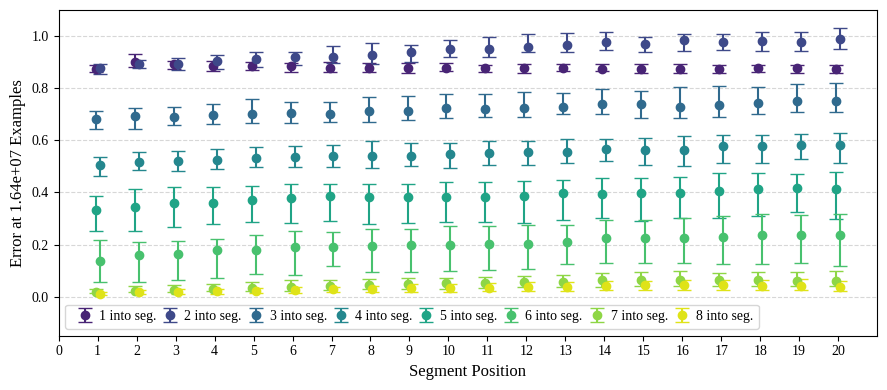

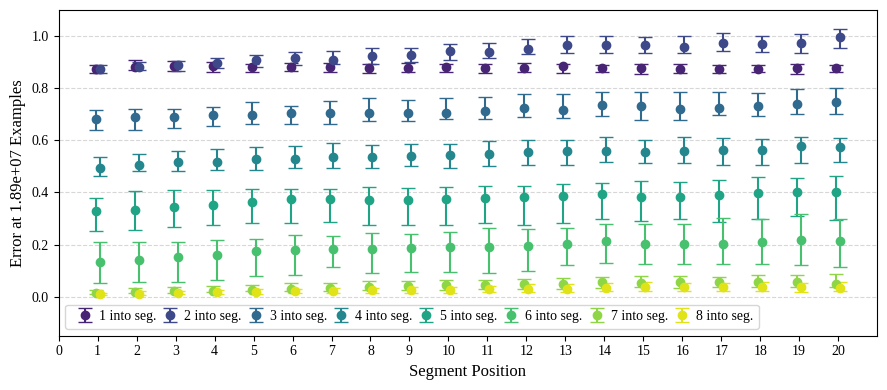

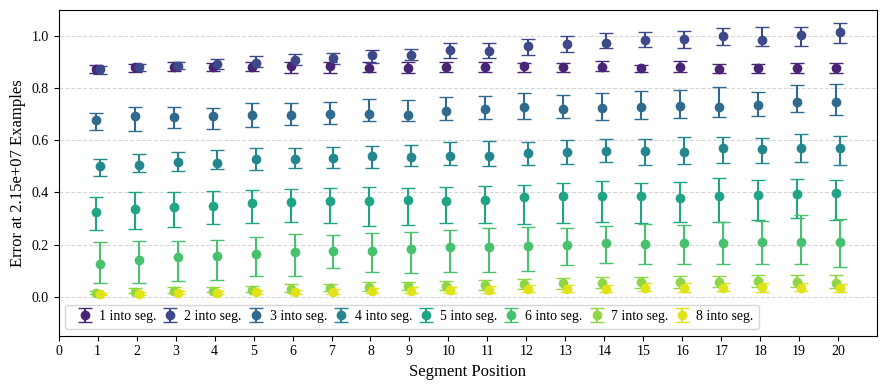

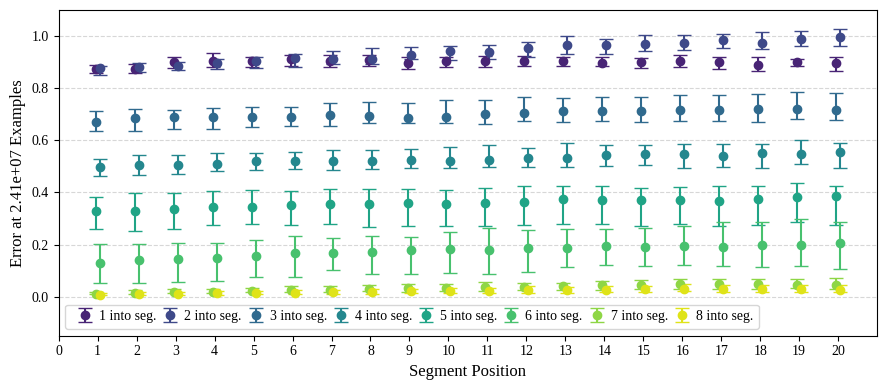

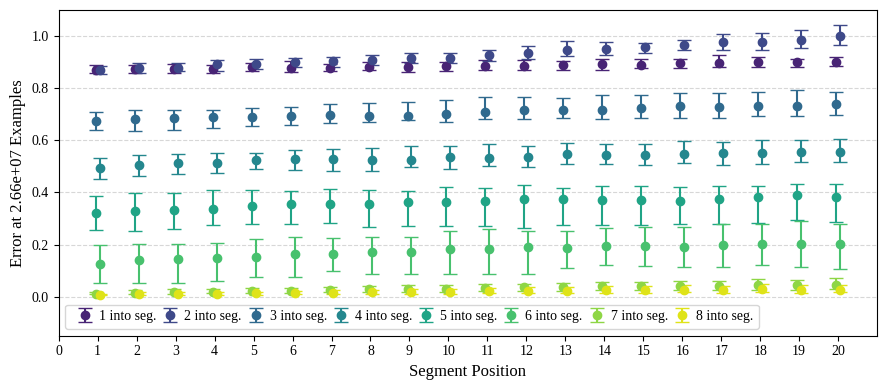

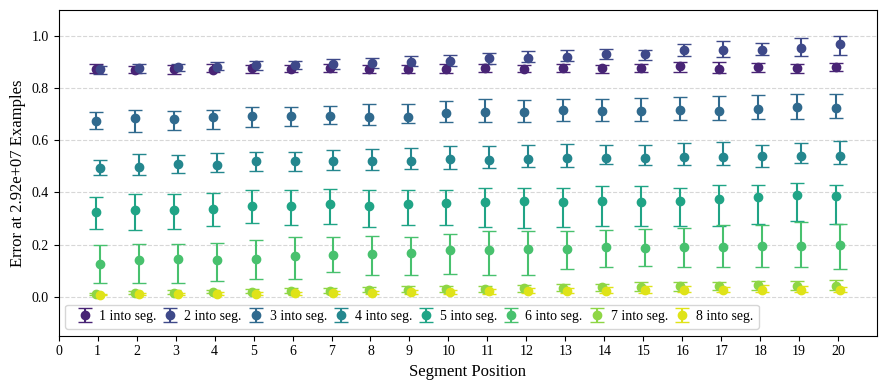

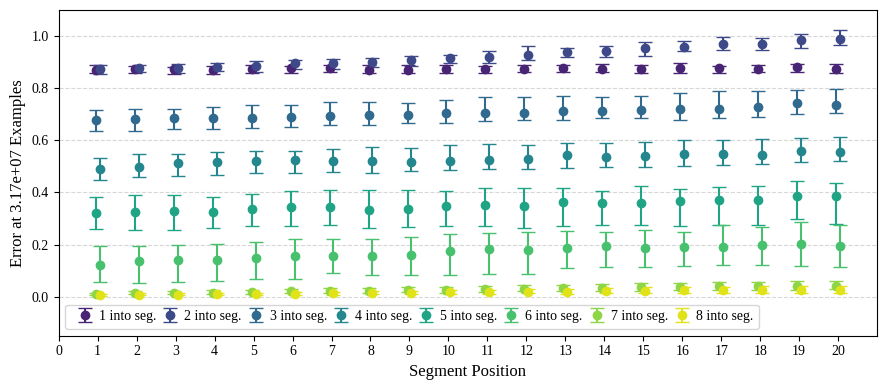

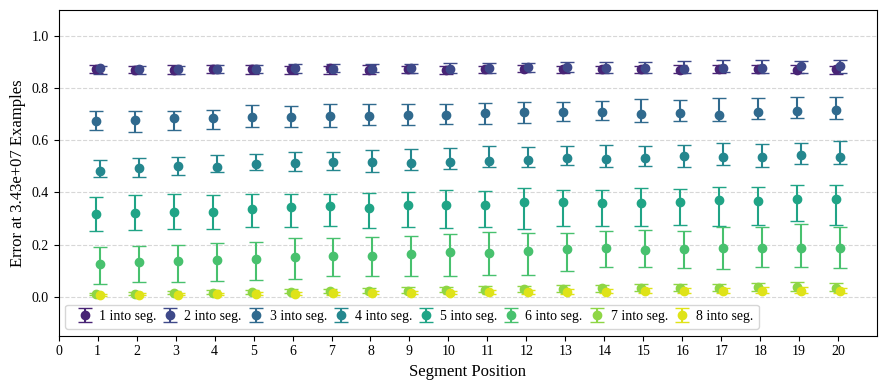

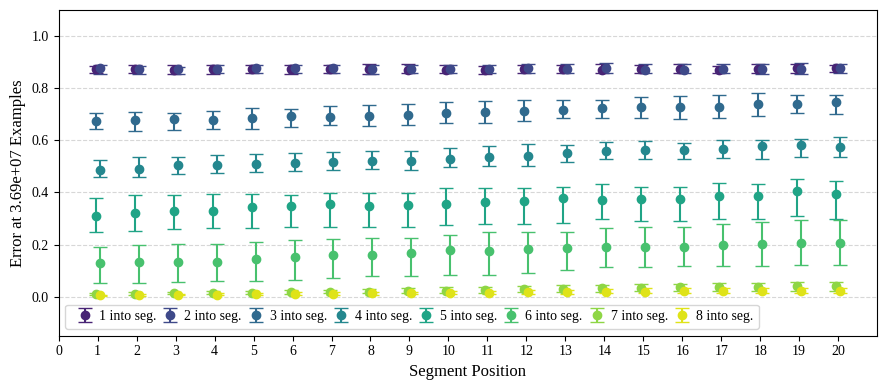

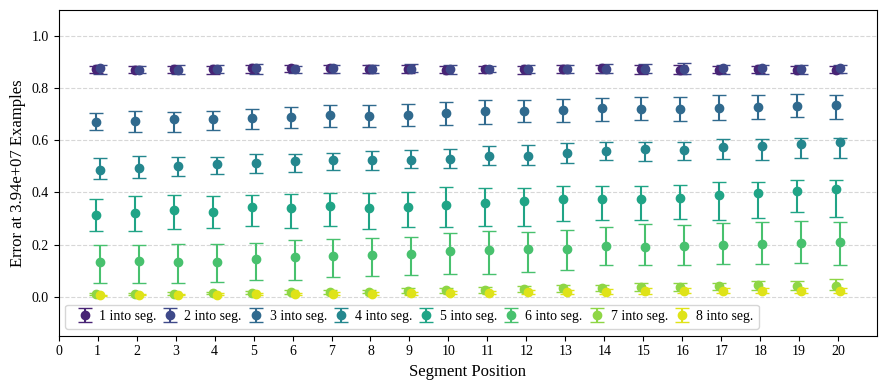

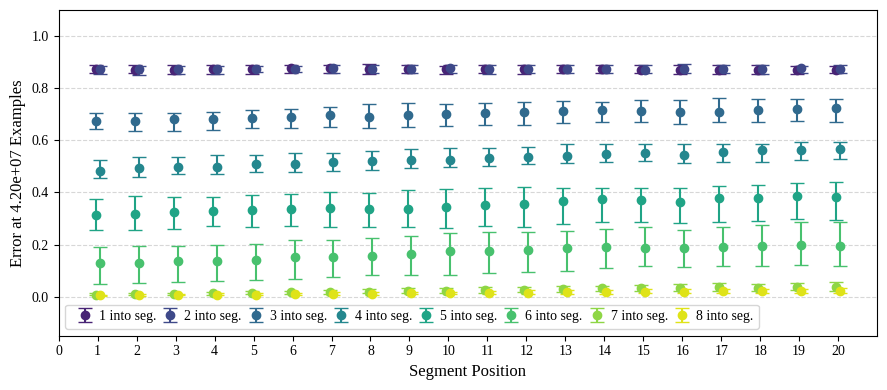

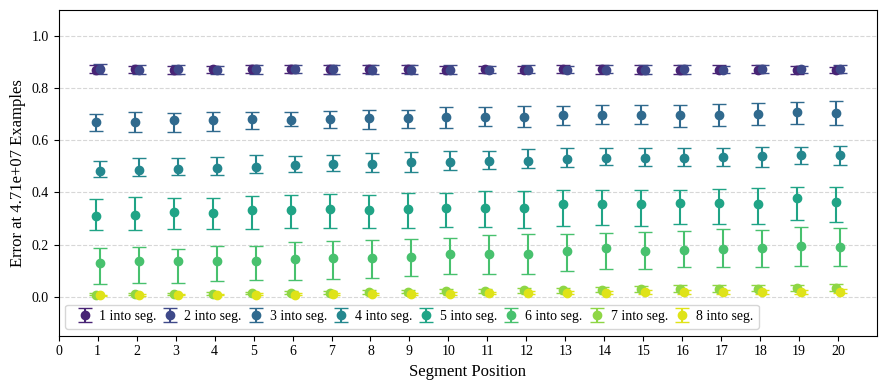

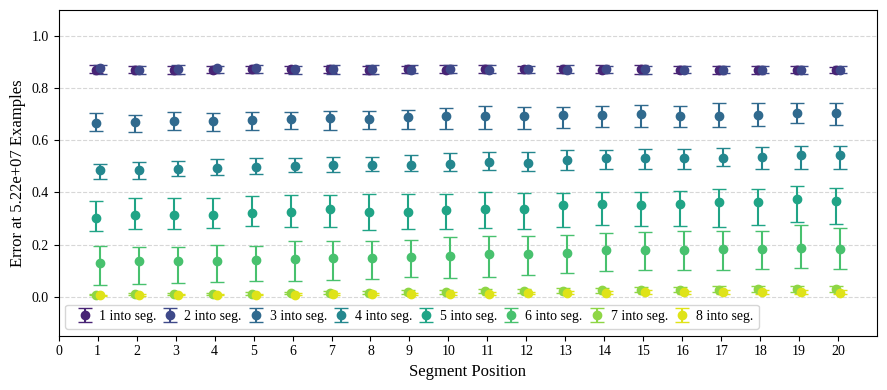

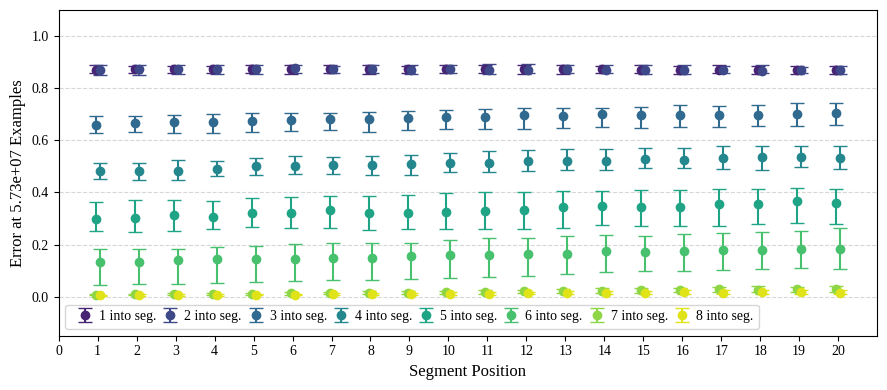

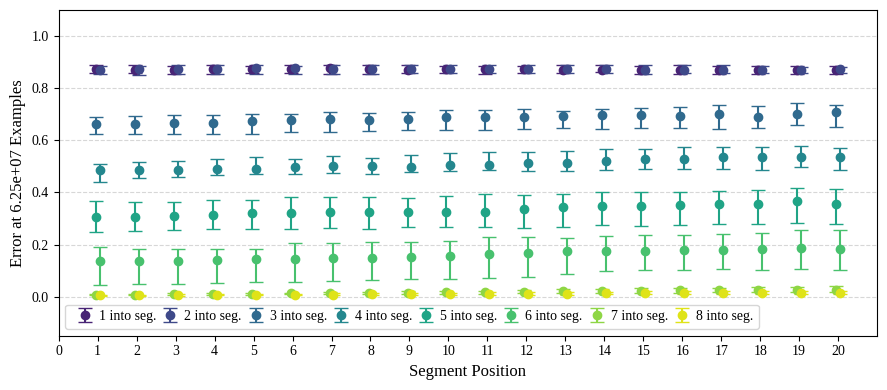

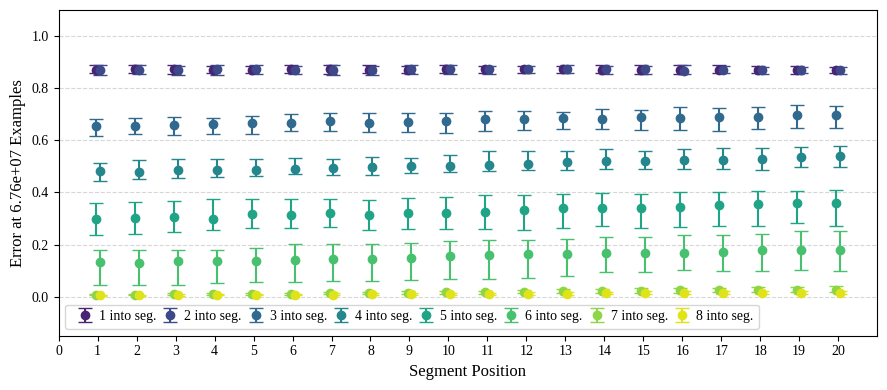

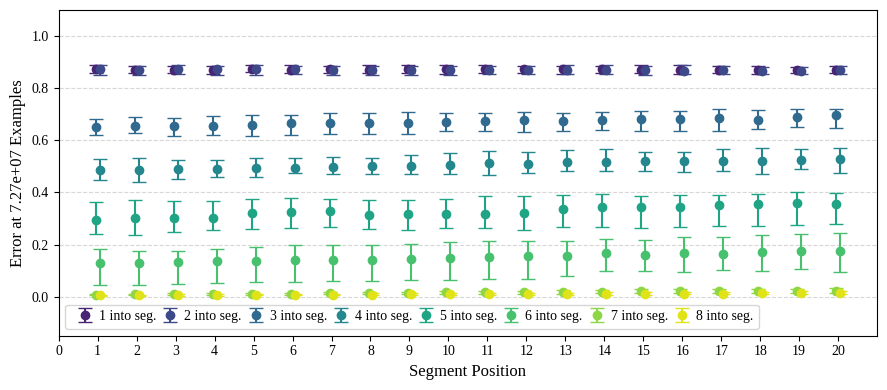

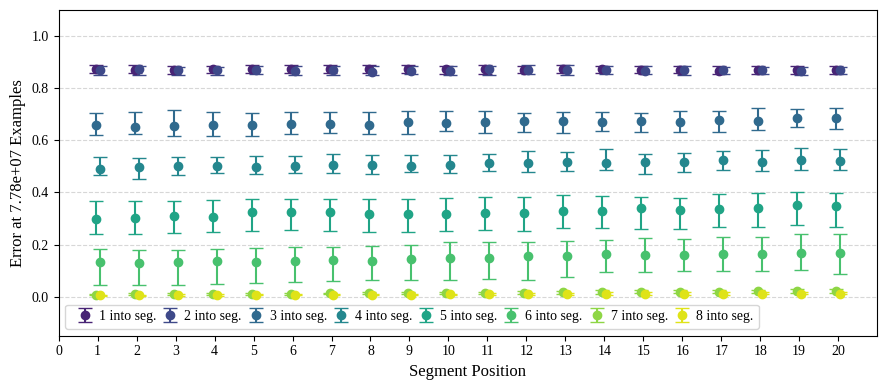

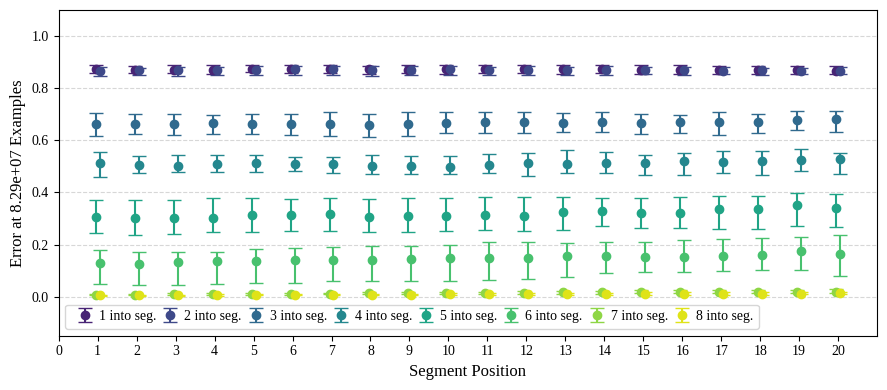

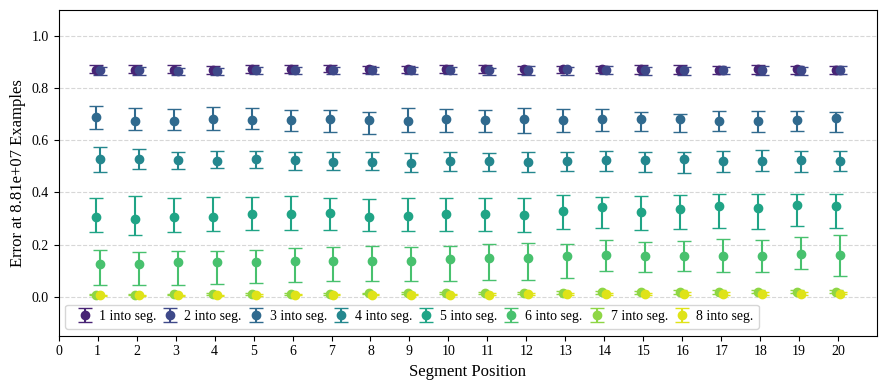

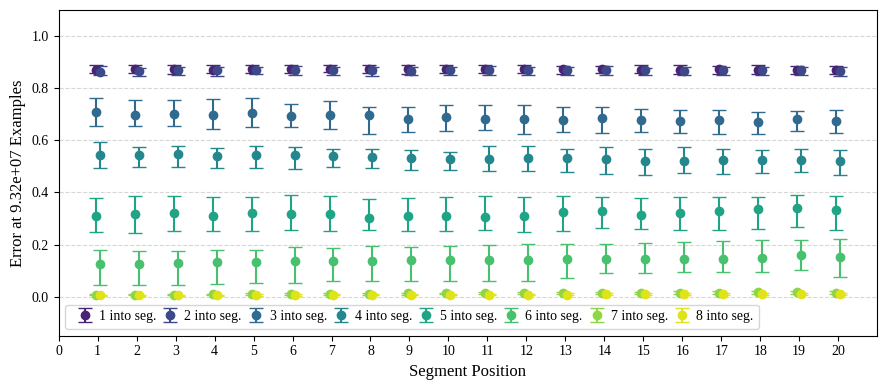

In [5]:
haystack_lens = np.arange(0, 20)
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

#load the data

#outputs/GPT2/250418_125901.8d6b22_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/irrelevant_tokens_new_hay_insert_train_conv_beg_quartiles_haystack_len_2.pkl
dither = 5e-2

x_values_path = f"{output_dir}/needles/train_conv/irrelevant_tokens_new_hay_insert_x_values_haystack_len_1.npy"

#load the x values npy file
x_values = np.load(x_values_path)



for index in range(len(x_values)):
    fig, ax = plt.subplots(1, 1, figsize=(9, 4))



    for hay_len in haystack_lens:
        if hay_len == 0:
            seg = "beg"
            file_len = hay_len + 1
        else:
            seg = "fin"
            file_len = hay_len

        data_path = f"{output_dir}/needles/train_conv/irrelevant_tokens_new_hay_insert_train_conv_{seg}_quartiles_haystack_len_{file_len}.pkl"

        x_values_path = f"{output_dir}/needles/train_conv/irrelevant_tokens_new_hay_insert_x_values_haystack_len_{file_len}.npy"

        #load the x values npy file
        x_values = np.load(x_values_path)

        #find the index of the x-values that has the value closest to 6.25e7
        # closest_index = (np.abs(x_values - 1e6)).argmin()
        # print(f"Closest index to 6.25e7: {closest_index}")
        # print(f"Closest x-value to 6.25e7: {x_values[closest_index]}")

        with open(data_path, "rb") as f:
            fin_quartiles = np.load(f, allow_pickle=True)
            fin_quartiles = fin_quartiles["MOP"]


        if len(fin_quartiles.keys()) > len(colors):
            colors = plt.cm.viridis(np.linspace(0.1, 0.95, len(fin_quartiles.keys())))
                                    
        col_count = 0
        for key in fin_quartiles.keys():
            x = hay_len + 1
            x_dither = x + (dither)*(-1)**key
            y = [fin_quartiles[key][index][1]]
            yerr = [[fin_quartiles[key][index][1] - fin_quartiles[key][index][0]],
                    [fin_quartiles[key][index][2] - fin_quartiles[key][index][1]]]
            
            ax.errorbar(x_dither, y, yerr=yerr, label=f"{key} into seg." if hay_len == 1 else "_nolegend_", fmt='o', capsize=5, color=colors[col_count])
            col_count += 1


    #scientific notation of x_values[closest_index] with 2 decimal places
    sci_not = "{:.2e}".format(x_values[index])

    ax.set_ylabel(f"Error at {sci_not} Examples", fontsize=12)
    ax.set_xlabel("Segment Position", fontsize=12)
    #set x ticks to be 1, 2, 3, ..., 20
    #concatenate 20 to the haystack_lens
    tks = np.concatenate((haystack_lens, [20]))
    # set y axis minor ticks
    # set y axis grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.5, which='both')

    ax.set_ylim([-0.15, 1.1])
    # ax.set_yscale("log")

    ax.set_xticks(tks)
    ax.legend(loc="lower left", ncols = 8, columnspacing=0.01, handletextpad=0.005, labelspacing=0.01, fontsize=10)

    fig_path = f"{output_dir}/figures/restart_sys/{config.val_dataset_typ}_n_embd_{config.n_embd}_restart_sys_num_exs_{sci_not}_lin.pdf"
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    fig.tight_layout()
    fig.savefig(fig_path, format='pdf')